# Libraries

In [ ]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from tqdm.notebook import tqdm_notebook
import random
from sklearn.preprocessing import OneHotEncoder

# Hyperparameters

In [ ]:
batchsize = 1024
learning_rate = 0.03
learning_rate_lc = 0.03
epochs = 100
threshold = 3.0
image_shape = (1,28,28)
image_1d_shape = np.prod(image_shape)
layers = [image_1d_shape,500,500,500,500]
softmax_layers = [0,1,2,3]

# Preparing the data

In [ ]:
train_dataset = MNIST("./data/",download=True, train=True, transform=ToTensor())
test_dataset = MNIST("./data/",download=True, train=False, transform=ToTensor())

train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, )
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 29525729.55it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 95835200.81it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27707121.18it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20288103.05it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
def label_to_oh(y):
    y = y.numpy().reshape(-1,1)
    ohe = OneHotEncoder().fit(np.arange(10).reshape((10,1)))
    ohe_y = ohe.transform(y).toarray()
    return torch.Tensor(ohe_y)

In [ ]:
def show_image(x):
    x = x.squeeze()
    plt.imshow(x, cmap="gray")
    plt.show()

# a) Define mask

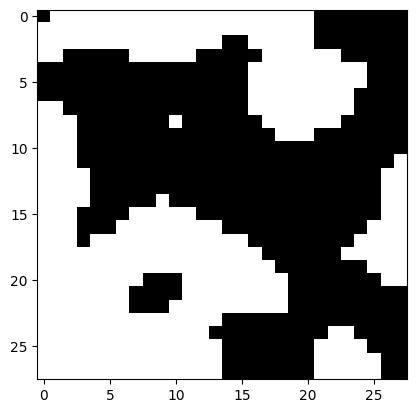

In [ ]:
# at first a mask of random 0s (black) and 1s (white)
# with the same dimensions as the image is created.
def define_mask():
    random_iter = np.random.randint(5,10)
    random_image = np.random.randint(2, size=image_shape).squeeze().astype(np.float32)
    blur_filter = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16
    for i in range(random_iter):
        random_image = convolve2d(random_image, blur_filter, mode='same', boundary='symm')
    mask = (random_image > 0.5).astype(np.float32)
    return mask

show_image(define_mask())

# b) Generate hybrid image

In [ ]:
# the hybrid image is created by adding one digit image times the mask
# and a different digit image times the reverse mask.
def negative_data_unsupervised(batch):
    batch = batch[0]
    indexes = torch.randperm(batch.shape[0])
    x1 = batch
    x2 = batch[indexes]
    mask = define_mask()
    merged_x1 = x1*mask
    merged_x2 = x2*(1-mask)
    hybrid_image = merged_x1+merged_x2
    return hybrid_image


# c) Implementation of the FF Network

In [ ]:
class FFLayer(nn.Linear):
    def __init__(self, in_features, out_features, bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = nn.ReLU()
        self.optimizer = Adam(self.parameters(), lr=learning_rate)
        self.threshold = threshold
        self.epoch_num = epochs

    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.relu(torch.mm(x_direction, self.weight.T) + self.bias.unsqueeze(0))

    def train(self, x_pos,x_neg):
        for i in range(self.epoch_num):
            out_pos = self.forward(x_pos).pow(2).mean(1)
            out_neg = self.forward(x_neg).pow(2).mean(1)
            loss = torch.log(1+ torch.exp(torch.cat([threshold-out_pos,out_neg-threshold]))).mean()
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()


class FFNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = []
        for i in range(len(layers)-1):
            self.layers.append(FFLayer(layers[i],layers[i+1]).cuda())

    def predict(self,x, softmax_layers):
        layers_output = torch.Tensor([]).cuda()
        h = x
        for i, layer in enumerate(self.layers):
            h = layer(h)
            if i in softmax_layers:
                layers_output = torch.cat([layers_output,h],1)

        return layers_output

    def train(self, x_pos, x_neg):
        out_pos, out_neg = x_pos, x_neg
        layer_loop = tqdm_notebook(enumerate(self.layers), leave=False)
        for i, layer in layer_loop:
            layer_loop.set_description(f"Training Layer: [{i+1}/{len(self.layers)}]")
            out_pos, out_neg = layer.train(out_pos, out_neg)

In [ ]:
# Training the FF Network
model = FFNet(layers)
model_train_loop = tqdm_notebook(iter(train_loader),leave=True)
for batch in model_train_loop:
    x_pos = batch[0]
    x_neg = negative_data_unsupervised(batch)
    x_pos, x_neg = x_pos.view(-1,image_1d_shape).cuda(), x_neg.view(-1,image_1d_shape).cuda()
    model.train(x_pos,x_neg)

  0%|          | 0/59 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

# d) Implementation of the Linear Classifier

In [ ]:
class LinearClassification(nn.Module):
    def __init__(self, input_dimension):
        super().__init__()
        self.epoch_losses = []
        self.linear = torch.nn.Linear(input_dimension, 10).cuda()
        self.optimizer = SGD(self.parameters(), lr=learning_rate_lc)
        self.criterion = nn.CrossEntropyLoss()
        self.softmax = nn.Softmax()

    def forward(self,x):
        return self.linear(x)

    def predict(self,x):
        x = x.view(-1,image_1d_shape).cuda()
        h_activity = model.predict(x,softmax_layers)
        y_h = self.forward(h_activity)
        soft_out = self.softmax(y_h)
        return soft_out.argmax()


    def train(self, data_loader,epoch_num):
        linear_loop = tqdm_notebook(range(epoch_num),total=epoch_num)
        for i in linear_loop:
            batch_losses = []
            for batch in iter(data_loader):
                x,y = batch
                x = x.view(-1,image_1d_shape).cuda()
                y_r = label_to_oh(y).cuda()
                h_activity = model.predict(x,softmax_layers)
                y_h = self.forward(h_activity)
                loss = self.criterion(y_h,y_r)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                batch_losses.append(loss)
            self.epoch_losses.append(float(sum(batch_losses)/len(batch_losses)))
            linear_loop.set_description(f"Epoch [{i+1}/{epoch_num}]: ")
            linear_loop.set_postfix(loss=self.epoch_losses[i])

    def test(self, data_loader):
        batch_losses = []
        test_loss = 0
        for batch in iter(data_loader):
            x,y = batch
            x = x.view(-1,image_1d_shape).cuda()
            y_r = label_to_oh(y).cuda()
            h_activity = model.predict(x,softmax_layers)
            y_h = self.forward(h_activity)
            loss = self.criterion(y_h,y_r)
            batch_losses.append(loss)
        test_loss = float(sum(batch_losses)/len(batch_losses))

        return test_loss



In [ ]:
def neuron_num(layers,softmax_layers):
    num = 0
    layers = layers[1:]
    for i in softmax_layers:
            num += layers[i]
    return num

In [ ]:
# Training the Linear Classifier

linear_model = LinearClassification(neuron_num(layers,softmax_layers))
losses = linear_model.train(train_loader,epochs)

  0%|          | 0/100 [00:00<?, ?it/s]

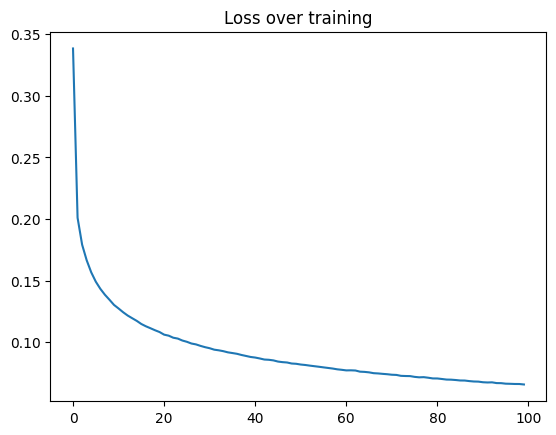

In [ ]:
plt.plot(linear_model.epoch_losses)
plt.title("Loss over training")
plt.show()

In [ ]:
print("test loss: ", linear_model.test(test_loader))

tensor([4, 4, 9,  ..., 0, 7, 1])
tensor([[ -1.7311,  -6.5663,  -3.8610,  ...,   1.6134,   0.3184,   2.3583],
        [ -7.5862,  -8.9406,   1.0945,  ...,   6.0575,   3.7595,   4.3177],
        [ -5.2649,   0.4649,  -0.5705,  ...,   7.6216,  -2.5675,   6.7179],
        ...,
        [ 14.6093,  -4.4550,   5.1926,  ...,  -4.2465,  -0.0361,  -1.7698],
        [ -5.7280, -11.5494,  -7.7760,  ...,  14.9573,  -9.1665,  14.7419],
        [ -8.0193,  12.8622,  -2.2159,  ...,   0.8615,   1.1804,   4.5033]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]], device='cuda:0')
tensor([6, 8, 2,  ..., 8, 4, 2])
tensor([[ 5.2765, -1.8111, -1.4544,  ..., -9.0502, -7.1927, -5.7026],
        [-3.2319, -1.7393, -1.2036,  ...,  2.1795,  4.6200,  2.0163],
   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


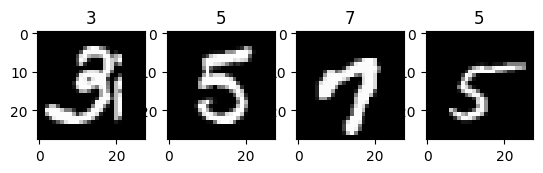

In [ ]:
batch = next(iter(test_loader))
n = 4
fig, ax1 = plt.subplots(1, n)
for i in range(n):
    x = batch[0][i]
    num=int(linear_model.predict(x))
    ax1[i].imshow(x.squeeze(),cmap="gray")
    ax1[i].set_title(str(num))
plt.show()

# Questions

## why linear classifier?

A common way to use contrastive learning for a supervised learning task is to first learn to transform
the input vectors into representation vectors without using any information about the labels and then
to learn a simple linear transformation of these representation vectors into vectors of logits which are
used in a softmax to determine a probability distribution over labels. This is called a linear classifier
despite its glaring non-linearity. The learning of the linear transformation to the logits is supervised,
but does not involve learning any hidden layers so it does not require backpropagation of derivatives.
FF can be used to perform this kind of representation learning by using real data vectors as the
positive examples and corrupted data vectors as the negative examples. There are many very different
ways to corrupt the data.